In [1]:
! head ./data/ml-1m/ratings.dat

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968
1::3408::4::978300275
1::2355::5::978824291
1::1197::3::978302268
1::1287::5::978302039
1::2804::5::978300719
1::594::4::978302268
1::919::4::978301368


In [2]:
import numpy as np
import random
from tqdm import tqdm

In [3]:
raw_data = np.loadtxt('./data/ml-1m/ratings.dat', delimiter='::')

In [4]:
class TriplesDataset(object):
    
    def __init__(self, raw_data, threshold_user = 20, threshold_item = 5, rnd_seed = 42):
        self.threshold_user = threshold_user
        self.threshold_item = threshold_item
        
        # fix randomness
        self.seed = rnd_seed
        np.random.seed(rnd_seed)
        random.seed(rnd_seed)
        
        # calculate user/item counts
        u_cnt = {}
        i_cnt = {}
        for row in tqdm(raw_data, desc='Calculate counts', leave=False):
            u, i, r, t = row.astype(int)
            u_cnt[u] = u_cnt.get(u, 0) + 1
            i_cnt[i] = i_cnt.get(i, 0) + 1

        # make blacklists
        u_blacklist = set([k for k, v in u_cnt.items() if v < threshold_user])
        i_blacklist = set([k for k, v in i_cnt.items() if v < threshold_item])
        
        # assemble self.data like {user:[(item, rating),...], ...}
        self.data = {}
        for row in tqdm(raw_data, desc='Assemble .data', leave=False):
            u, i, r, t = list(map(int, row))
            # filtering rare
            if u in u_blacklist or i in i_blacklist:
                continue
            self.data[u] = self.data.get(u, []) + [(i, r)]
        self.data_keys = list(self.data.keys())
        self.train_pool = None
    
    
    def train_test_split(self, n_train=None, n_test=None):
        assert n_train is None or n_test is None, 'both n_train and n_test cannot be set'
        #assert not (n_train is None and n_test is None), 'both n_train and n_test cannot be None'
        assert n_test is None, 'n_test not supported for now'
        
        # .train : {user: {rating: [items, ...], ...}}
        self.train = {}
            
        # .test : {user: [(item, rating), ..]} [sorted by rating]
        self.test = {}
            
        for u in tqdm(self.data, desc='Split users', leave=False):
            rnd_inds = set(np.random.choice(len(self.data[u]), n_train or n_test, False))
            for n, pair in enumerate(self.data[u]):
                if n in rnd_inds:
                    i, r = pair
                    user_dict = self.train.get(u, {})
                    rating_list = user_dict.get(r, [])
                    rating_list.append(i)
                    user_dict[r] = rating_list
                    self.train[u] = user_dict
                else:
                    self.test[u] = self.test.get(u, []) + [pair]
            if len(self.train[u].keys())==1:
                print('No rating diversity in train for user {}, do swap!'.format(u))
                the_only_rating = list(self.train[u].keys())[0]
                for n, (i, r) in enumerate(self.test[u]):
                    if r!=the_only_rating:
                        self.train[u][r] = [i]
                        extracted_i = self.train[u][the_only_rating][0]
                        self.train[u][the_only_rating] = self.train[u][the_only_rating][1:]
                        del self.test[u][n]
                        self.test[u] = self.test[u] + [(extracted_i, the_only_rating)]
                        break
            self.test[u] = sorted(self.test[u], key=lambda x: x[1], reverse=True)

                    
    def sample_train_triple(self):
        user = random.choice(self.data_keys)
        stats = self.train[user]
        stats_keys = list(stats.keys())
        # assert len(stats_keys) > 1, 'user {} has only 1 rating!'.format(user)
        if len(stats_keys) == 1:
            print('user {} has only 1 rating!'.format(user))
        left_rating, right_rating = random.sample(stats_keys, 2)
        left_value = random.choice(stats[left_rating])
        right_value = random.choice(stats[right_rating])
        y = (left_rating > right_rating)*2 - 1
        return (user, left_value, right_value, y)
    
    
    def sample_train_batch(self,n_samples=256):
        retval = np.zeros((n_samples, 4)).astype(np.int32)
        for i in range(n_samples):
            retval[i] = self.sample_train_triple()
        return {
            'users': retval[:, 0], 
            'left_items': retval[:, 1],
            'right_items': retval[:, 2],
            'y': retval[:, 3].astype(np.float32),
        }

In [5]:
ds = TriplesDataset(raw_data, threshold_user=30, rnd_seed=42)
ds.train_test_split(n_train=20)

Split users:  76%|███████▌  | 4007/5289 [00:01<00:00, 2841.25it/s]

No rating diversity in train for user 3598, do swap!
No rating diversity in train for user 4486, do swap!


In [6]:
%%time
for _ in range(1000):
    ds.sample_train_batch(n_samples=256)

CPU times: user 3.11 s, sys: 12.8 ms, total: 3.12 s
Wall time: 3.13 s


# define model

In [7]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [8]:
N_USERS = int(max(raw_data[:, 0])) + 1
N_ITEMS = int(max(raw_data[:, 1])) + 1
N_HIDDEN = 10

In [9]:
# placeholders
user_ids  = tf.placeholder(tf.int32, (None,), name='user_ids')
left_ids  = tf.placeholder(tf.int32, (None,), name='left_ids')
right_ids = tf.placeholder(tf.int32, (None,), name='right_ids')
target_y  = tf.placeholder(tf.float32, (None,), name='target_y')
alpha_reg = .5

# main parameters
user_latents = tf.Variable(tf.random_uniform(shape=(N_USERS, N_HIDDEN)), trainable=True, name='user_latents')
item_latents = tf.Variable(tf.random_uniform(shape=(N_ITEMS, N_HIDDEN)), trainable=True, name='item_latents')

## define batch processing

# get embeddings for batch
embedding_user  = tf.nn.embedding_lookup(user_latents, user_ids, name='embedding_user')
embedding_left  = tf.nn.embedding_lookup(item_latents, left_ids, name='embedding_left')
embedding_right = tf.nn.embedding_lookup(item_latents, right_ids, name='embedding_right')

# raw margins for primal ranking loss
embedding_diff = embedding_left - embedding_right

# shape: [n_batch, ]
embedding_margins = tf.reduce_sum(tf.mul(embedding_user, embedding_diff), axis=1, name='embedding_margins')

In [10]:
import tensorflow.contrib.slim as slim
def network(user_emb, item_emb):
    joined_input = tf.concat(1, [user_emb, item_emb])
    net = slim.fully_connected(inputs=joined_input, num_outputs=64, activation_fn=tf.nn.relu)
    net = slim.fully_connected(inputs=net, num_outputs=32, activation_fn=tf.nn.relu)
    net = slim.fully_connected(inputs=net, num_outputs=16, activation_fn=tf.nn.relu)
    net = slim.fully_connected(inputs=net, num_outputs=1, activation_fn=None)
    return net

def mean_logloss(raw_margins, target_values, tag):
    # -y*f(x)
    myfx = -1*tf.mul(target_values, raw_margins)
    elementwise_logloss = tf.minimum(tf.log(1 + tf.exp(myfx)), 100, name='elwise_' + tag)
    mean_loss = tf.reduce_mean(elementwise_logloss, name='mean_' + tag)
    return mean_loss



# apply shared net
with tf.variable_scope("nn"):
    left_output = network(embedding_user, embedding_left)
with tf.variable_scope("nn", reuse=True):
    right_output = network(embedding_user, embedding_right)

# margins for net output
net_margins = left_output - right_output

# shape: [n_batch, 1] -> [n_batch, ]
net_margins = tf.squeeze(net_margins, axis=1, name='net_margins')

In [11]:
# losses
embedding_loss = mean_logloss(embedding_margins, target_y, 'embedding_loss')
net_loss = mean_logloss(net_margins, target_y, 'net_loss')

target = alpha_reg * embedding_loss + (1 - alpha_reg) * net_loss

In [12]:
trainer_2 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(target)
trainer_3 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(target)
trainer_4 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(target)

In [13]:
init_vars = tf.global_variables_initializer()
sess.run(init_vars)

In [ ]:
losses = []
n_batches = 15000
batch_size = 256
for i in tqdm(range(n_batches)):
    batch = ds.sample_train_batch(n_samples=batch_size)
    fd = {
        user_ids:  batch['users'], 
        left_ids:  batch['left_items'],
        right_ids: batch['right_items'],
        target_y:  batch['y'],
    }
    el, nl, _ = sess.run([embedding_loss, net_loss, trainer_3], feed_dict=fd)
    losses.append((el, nl))

  4%|▍         | 605/15000 [00:04<01:42, 140.68it/s]

In [16]:
%pylab inline
import random

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


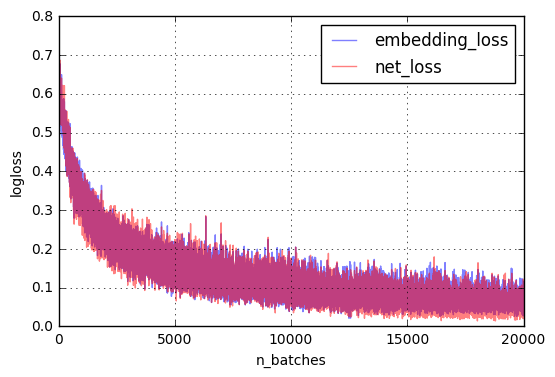

In [21]:
plot([x[0] for x in losses], c='b', label='embedding_loss', alpha=0.5)
plot([x[1] for x in losses], c='r', label='net_loss', alpha=0.5)
grid()
legend()
xlabel('n_batches')
ylabel('logloss')

In [28]:
u = 1
fd = {
        user_ids:  (np.ones(N_ITEMS)*u).astype(np.int32), 
        left_ids:  np.array(range(N_ITEMS)).astype(np.int32),
    }
response = sess.run(left_output, feed_dict=fd)[:, 0]

In [31]:
INF = 10e+5
response[0] = -INF
for rating, items in ds.train[u].items():
    for i in items:
        response[i] = -INF

In [34]:
np.argsort(-response)[:20]

array([3910, 1217, 2810, ...,  594, 3114,    0])

In [35]:
response[3910]

33.20269

In [36]:
ds.test[1]

[(1193, 5),
 (661, 3),
 (914, 3),
 (2804, 5),
 (919, 4),
 (595, 5),
 (938, 4),
 (1035, 5),
 (2791, 4),
 (2687, 3),
 (3105, 5),
 (2321, 3),
 (720, 3),
 (1270, 5),
 (527, 5),
 (48, 5),
 (1721, 4),
 (1545, 4),
 (745, 3),
 (2294, 4),
 (3186, 4),
 (783, 4),
 (1836, 5),
 (2762, 4),
 (150, 5),
 (1, 5),
 (1962, 4),
 (1028, 5),
 (1029, 5),
 (2028, 5),
 (531, 4),
 (608, 4),
 (1246, 4)]